In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, utils, datasets


In [8]:
IMG_PATH = "CHNCXR_0001_0.png"

In [9]:
img = cv2.imread(IMG_PATH)

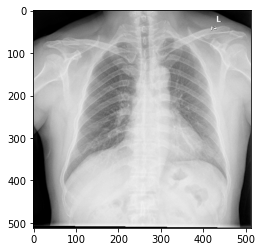

In [10]:
plt.imshow(img)

In [5]:
def get_edges(image, sigma=0.33):
    blur_image = cv2.GaussianBlur(image, (3, 3), 0)
    blur_median = np.median(blur_image)
    lower = int(max(0, (1.0 - sigma) * blur_median))
    upper = int(min(255, (1.0 + sigma) * blur_median))
    
    edges = cv2.Canny(blur_image, lower, upper)
    
    return edges



def array_to_img_for_viz(arr, beta=255):
    arr = arr * beta
    arr = arr.squeeze()
    arr = np.uint8(arr)
    
    return arr
    
    
    
def preprocess_img(input_img):
    IMAGE_LABEL_SIZE = 224

    image_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])


    img = cv2.resize(input_img, (IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE))
    img_tensor = image_transforms(img).unsqueeze(0)
    
    return img_tensor



def make_prediction(input_tensor):
    model.eval()
    y_test_pred = model(input_tensor)
    y_test_pred = torch.log_softmax(y_test_pred, dim=1)
    _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    y_pred_tag = y_pred_tag.numpy()
    
    
    return y_pred_tag

In [6]:
class ModelFCN8(nn.Module):
    def __init__(self, num_class):
        super(ModelFCN8, self).__init__()
        self.num_class = num_class
        
        self.block_1_1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block_1_2 = self.conv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.block_2_1 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_2 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_3 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.block_3_1 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_2 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_3 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.block_4_1 = self.conv_block(c_in=256, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.block_5_1 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_512_4096 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=1, stride=1, padding=0)
        
        
        self.conv1x1_4096_numclass = nn.Conv2d(in_channels=4096, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_512_numclass = nn.Conv2d(in_channels=512, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_256_numclass = nn.Conv2d(in_channels=256, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        
        self.upsample_pool5_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool4_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool3_8x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=8, stride=8)
        
        self.final_conv = nn.Conv2d(in_channels=num_class, out_channels=num_class, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
    def forward(self, x):
                              # 3 x 224 x 224
        x1 = self.block_1_1(x)
        x1 = self.block_1_2(x1)
        
        x1 = self.maxpool(x1) # 64 x 112 x 112
        
        x2 = self.block_2_1(x1)
        x2 = self.block_2_2(x2)
        x2 = self.block_2_3(x2)
        
        x2 = self.maxpool(x2) # 128 x 56 x 56
        
        x3 = self.block_3_1(x2)
        x3 = self.block_3_2(x3)
        x3 = self.block_3_3(x3)
        
        x3 = self.maxpool(x3) # 256 x 28 x 28
        p3 = self.conv1x1_256_numclass(x3) # 8 x 28 x 28
        
        x4 = self.block_4_1(x3)
        x4 = self.block_4_2(x4)
        x4 = self.block_4_3(x4)
        
        x4 = self.maxpool(x4) # 512 x 14 x 14
        p4 = self.conv1x1_512_numclass(x4) # 8 x 14 x 14
        
        x5 = self.block_5_1(x4)
        x5 = self.block_5_2(x5)
        x5 = self.block_5_3(x5) 
        
        x5 = self.maxpool(x5) # 512 x 7 x 7
        
        x5 = self.conv1x1_512_4096(x5) # 4096 x 7 x 7
        p5 = self.conv1x1_4096_numclass(x5) # 8 x 7 x 7
        
        
        # Upsampling using transposed convolutions
        o1 = self.upsample_pool5_2x(p5) # 8 x 14 x14
        o1 = o1 + p4
        o2 = self.upsample_pool4_2x(o1) # 8 x 28 x 28
        o2 = o2 + p3
        o3 = self.upsample_pool3_8x(o2) # 8 x 224 x 224
        
        
        output = self.final_conv(o3) # 8 x 224 x 224


        return output

        
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [7]:
model = torch.load("model_lung_seg_fcn8_40", map_location=torch.device('cpu'))

In [8]:
img_tensor = preprocess_img(img)

In [9]:
pred = make_prediction(img_tensor)
pred = array_to_img_for_viz(pred)

Text(0.5, 1.0, 'Superimposed Image and Boundary')

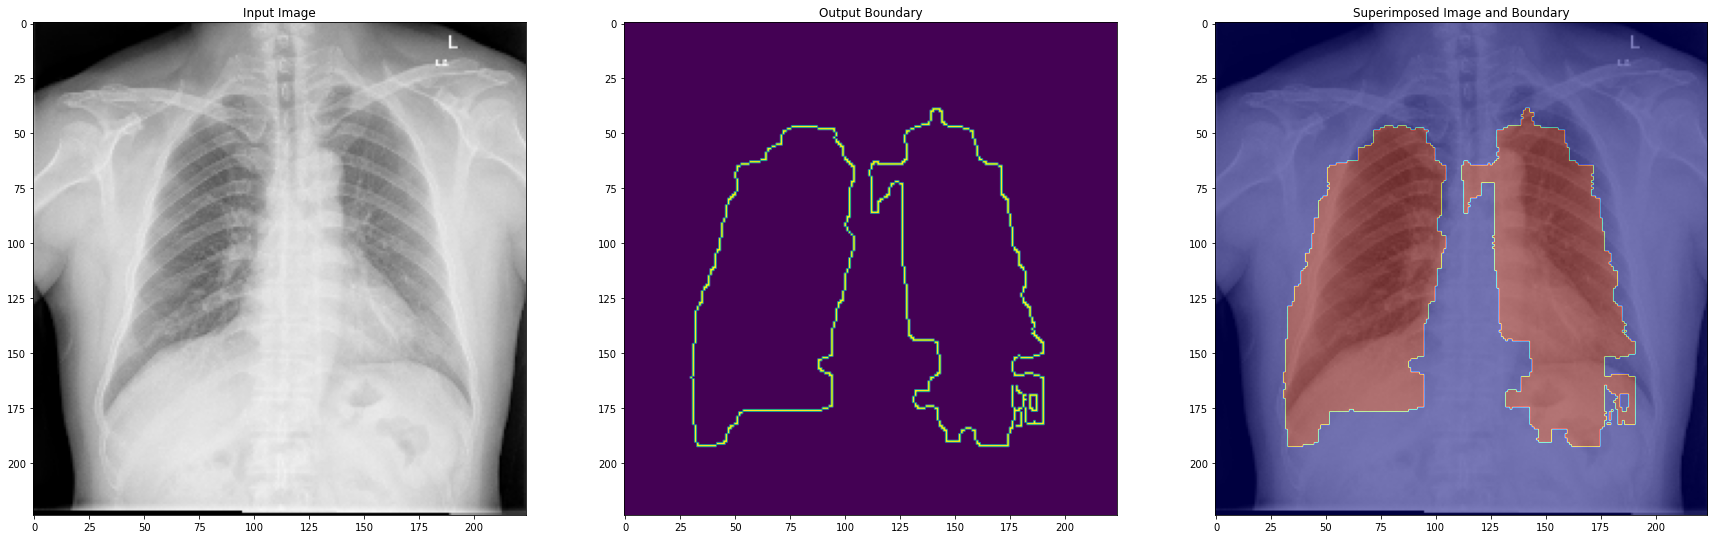

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,10))
axes[0].imshow(cv2.resize(img, (224, 224)))
axes[0].set_title("Input Image")
axes[1].imshow(get_edges(pred))
axes[1].set_title("Output Boundary")
axes[2].imshow(cv2.resize(img, (224, 224)), cmap='gray')
axes[2].imshow(pred, cmap='jet', alpha=0.5)
axes[2].set_title("Superimposed Image and Boundary")